In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
%matplotlib inline
### imports ###
import sys
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib_venn import venn3
import seaborn as sns

matplotlib.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from homer_preprocessing import import_homer_diffgene, read_homer_gene_exp, read_annotated_peaks
from plotting_scripts import plot_exp_rpkm, gene_list_bar_plot

In [2]:
workingDirectory = '/home/h1bennet/strains_rna/results/K03_CB6F1_Kupffer_RNA/'
dataDirectory = '/home/ttroutman/strainsKupffer/rnaKupfferF1/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

if not os.path.isdir('./figures/'):
    os.mkdir('./figures/')

To do this analysis we will pull from the differential analysis performed by Ty at the following location:  

     /home/ttroutman/strainsKupffer/rnaKupfferF1/
     
The following two files are relevant  

     /home/ttroutman/strainsKupffer/rnaKupfferF1/c57bl6j_perfect.vs.balbcj_perfect.scatter.txt
     /home/ttroutman/strainsKupffer/rnaKupfferF1/c57bl6j_control.vs.balbcj_control.scatter.txt

In [3]:
diffDir = '/home/ttroutman/strainsKupffer/rnaKupfferNASH/thresholdOutHepatocyteGenes_TPM_NASH_ctrl/rnaDiff_filter_join'
rnaQuan = '/home/ttroutman/strainsKupffer/rnaKupfferF1/rnaQuan/rawT.txt'


In [4]:
tpm = pd.read_csv(rnaQuan,
                  index_col=0,
                  sep='\t')

In [5]:
(tpm==0).sum()

balbcj_variants_rep1     16992
balbcj_variants_rep2     16916
balbcj_variants_rep3     16937
balbcj_variants_rep4     17045
c57bl6j_variants_rep1    16984
c57bl6j_variants_rep2    16945
c57bl6j_variants_rep3    16882
c57bl6j_variants_rep4    17067
balbcj_perfect_rep1       7262
balbcj_perfect_rep2       7039
balbcj_perfect_rep3       7110
balbcj_perfect_rep4       7252
c57bl6j_perfect_rep1      7273
c57bl6j_perfect_rep2      7055
c57bl6j_perfect_rep3      7095
c57bl6j_perfect_rep4      7250
balbcj_control_rep1       8914
balbcj_control_rep2       8990
c57bl6j_control_rep1      8553
c57bl6j_control_rep2      8832
dtype: int64

In [6]:
groups = ['balbcj_variants',
          'c57bl6j_variants',
          'balbcj_perfect',
          'c57bl6j_perfect',
          'balbcj_control',
          'c57bl6j_control']

log2tpm_thresh = 3.169925

In [7]:
avg_tpm_dict = {}
for group in groups:
    avg = tpm.loc[:, tpm.columns.str.contains(group)].mean(1)
    avg_tpm_dict[group] = avg
    
avg_tpm_df = pd.DataFrame(avg_tpm_dict)
# log transform data
log_tpm_df = np.log2(avg_tpm_df+1)
# filter on expression
log_tpm_df = log_tpm_df.reindex(log_tpm_df.index[(log_tpm_df > log2tpm_thresh).any(1)])

calculate fold changes for each comparison of interest

# Check with ty that  "variants" are perfectly aligned reads overlapping variants

In [8]:
log_tpm_df['f1_fc_perfect'] = log_tpm_df['c57bl6j_perfect'] - log_tpm_df['balbcj_perfect']
log_tpm_df['f1_fc_variants'] = log_tpm_df['c57bl6j_variants'] - log_tpm_df['balbcj_variants']
log_tpm_df['p1_fc'] = log_tpm_df['c57bl6j_control'] - log_tpm_df['balbcj_control']

### set gene lists
For plotting we don't care about directionality, but for extracting gene lists we will have to
pull out balb biased and c57 biased trans genes

In [9]:
cis = np.abs(log_tpm_df.p1_fc - log_tpm_df.f1_fc_variants) < 1
trans = ((~cis) &(np.abs(log_tpm_df.p1_fc) > 1) & ((np.abs(log_tpm_df.f1_fc_variants) < 1)))
mixed = (~cis) & (~trans)

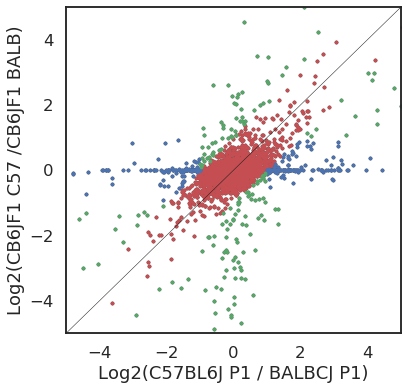

In [11]:
fig, ax = plt.subplots(figsize=(6,6))


ax.plot([-10,10],
        [-10,10],
        c='k',
        linewidth=0.5)

ax.scatter(log_tpm_df.p1_fc,
           log_tpm_df.f1_fc_variants,
           s=5,
           c='k')

ax.scatter(log_tpm_df.p1_fc[cis],
           log_tpm_df.f1_fc_variants[cis],
           s=5,
           c='r')

ax.scatter(log_tpm_df.p1_fc[trans],
           log_tpm_df.f1_fc_variants[trans],
           s=5,
           c='b')

ax.scatter(log_tpm_df.p1_fc[mixed],
           log_tpm_df.f1_fc_variants[mixed],
           s=5,
           c='g')
ax.set_xlabel('Log2(C57BL6J P1 / BALBCJ P1)')
ax.set_ylabel('Log2(CB6JF1 C57 /CB6JF1 BALB)')

ax.set_xlim([-5,5]);
ax.set_ylim([-5,5]);

In [12]:
trans_c57 = ((~cis) & ((log_tpm_df.p1_fc) > 1) & (np.abs(log_tpm_df.f1_fc_variants) < 1))
trans_balb = ((~cis) & ((log_tpm_df.p1_fc) < -1) & (np.abs(log_tpm_df.f1_fc_variants) < 1))
mixed_c57 = ((~cis) & ((np.abs(log_tpm_df.p1_fc) < 1) & ((log_tpm_df.f1_fc_variants) > 1)))
mixed_balb = ((~cis) & ((np.abs(log_tpm_df.p1_fc) < 1) & ((log_tpm_df.f1_fc_variants) < -1)))

In [ ]:
lists = [trans_c57, trans_balb, mixed_c57, mixed_balb]
labels = ['trans_c57', 'trans_balb', 'mixed_c57', 'mixed_balb']

## Write out gene list

In [ ]:
if not os.path.isdir('./gene_lists/'):
    os.mkdir('./gene_lists')

In [ ]:
for label, genelist in zip(labels, lists):
    with open('./gene_lists/cb6f1_kupffer_'+label+'.txt', 'w') as f:
        f.write('Gene\n')
        for i in genelist.index[genelist].tolist():
            f.write(i+'\n')
        f.close()

# Make plot for only variants

In [18]:
no_vars = (log_tpm_df.balbcj_variants==0) & (log_tpm_df.c57bl6j_variants==0) 

In [19]:
log_tpm_df_filt = log_tpm_df.reindex(log_tpm_df.index[~no_vars])

In [20]:
cis = np.abs(log_tpm_df_filt.p1_fc - log_tpm_df_filt.f1_fc_variants) < 1
trans = ((~cis) &(np.abs(log_tpm_df_filt.p1_fc) > 1) & ((np.abs(log_tpm_df_filt.f1_fc_variants) < 1)))
mixed = (~cis) & (~trans)

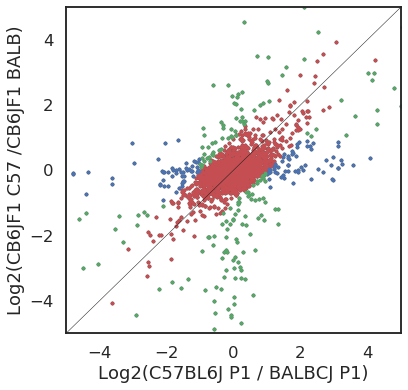

In [21]:
fig, ax = plt.subplots(figsize=(6,6))


ax.plot([-10,10],
        [-10,10],
        c='k',
        linewidth=0.5)

ax.scatter(log_tpm_df_filt.p1_fc,
           log_tpm_df_filt.f1_fc_variants,
           s=5,
           c='k')

ax.scatter(log_tpm_df_filt.p1_fc[cis],
           log_tpm_df_filt.f1_fc_variants[cis],
           s=5,
           c='r')

ax.scatter(log_tpm_df_filt.p1_fc[trans],
           log_tpm_df_filt.f1_fc_variants[trans],
           s=5,
           c='b')

ax.scatter(log_tpm_df_filt.p1_fc[mixed],
           log_tpm_df_filt.f1_fc_variants[mixed],
           s=5,
           c='g')
ax.set_xlabel('Log2(C57BL6J P1 / BALBCJ P1)')
ax.set_ylabel('Log2(CB6JF1 C57 /CB6JF1 BALB)')

ax.set_xlim([-5,5]);
ax.set_ylim([-5,5]);

In [23]:
trans_c57_filt = ((~cis) & ((log_tpm_df_filt.p1_fc) > 1) & (np.abs(log_tpm_df_filt.f1_fc_variants) < 1))
trans_balb_filt = ((~cis) & ((log_tpm_df_filt.p1_fc) < -1) & (np.abs(log_tpm_df_filt.f1_fc_variants) < 1))
mixed_c57_filt = ((~cis) & ((np.abs(log_tpm_df_filt.p1_fc) < 1) & ((log_tpm_df_filt.f1_fc_variants) > 1)))
mixed_balb_filt = ((~cis) & ((np.abs(log_tpm_df_filt.p1_fc) < 1) & ((log_tpm_df_filt.f1_fc_variants) < -1)))

In [24]:
lists = [trans_c57_filt, trans_balb_filt, mixed_c57_filt, mixed_balb_filt]
labels = ['trans_c57_filt', 'trans_balb_filt', 'mixed_c57_filt', 'mixed_balb_filt']

In [25]:
for label, genelist in zip(labels, lists):
    with open('./gene_lists/cb6f1_kupffer_'+label+'.txt', 'w') as f:
        f.write('Gene\n')
        for i in genelist.index[genelist].tolist():
            f.write(i+'\n')
        f.close()

# Plot single genes using barplot

In [110]:
tpm_mat = pd.read_csv(rnaQuan,
                      index_col=0,
                      sep='\t')

In [111]:
tpm_mat.columns

Index(['balbcj_variants_rep1', 'balbcj_variants_rep2', 'balbcj_variants_rep3',
       'balbcj_variants_rep4', 'c57bl6j_variants_rep1',
       'c57bl6j_variants_rep2', 'c57bl6j_variants_rep3',
       'c57bl6j_variants_rep4', 'balbcj_perfect_rep1', 'balbcj_perfect_rep2',
       'balbcj_perfect_rep3', 'balbcj_perfect_rep4', 'c57bl6j_perfect_rep1',
       'c57bl6j_perfect_rep2', 'c57bl6j_perfect_rep3', 'c57bl6j_perfect_rep4',
       'balbcj_control_rep1', 'balbcj_control_rep2', 'c57bl6j_control_rep1',
       'c57bl6j_control_rep2'],
      dtype='object')

In [34]:
groups = [[0,1,2,3],
          [4,5,6,7],
          #[8,9,10,11],
          #[12,13,14,15],
          [16,17],
          [18,19]]

group_labels = ['CB6F1 Balb/cJ Variant',
                'CB6F1 C57BL/6J Variant',
                #'CB6F1 Balb/cJ Perfect',
                #'CB6F1 C57BL/6J Perfect',
                'Balb/cJ Control',
                'C57BL/6J Control',]

colors = ['#9ecae1',
          '#a1d99b',
          #'#6baed6',
          #'#74c476',
          '#08519c',
          '#31a354']

In [35]:
legend_elements = []
for lab, col in  zip(group_labels, colors):
    legend_elements.append(Patch(label=lab, color=col))

[]

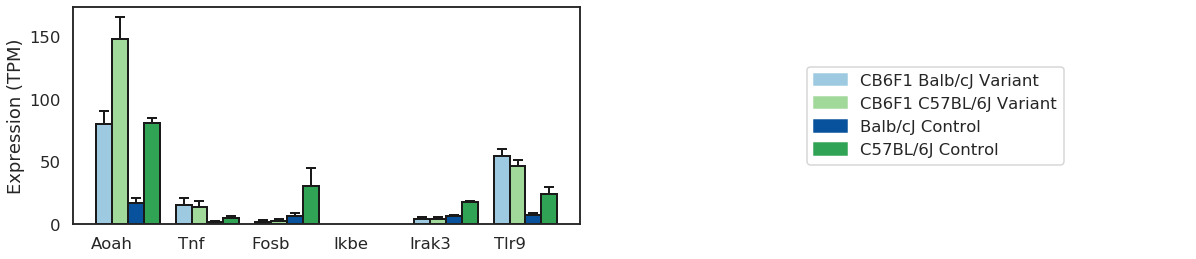

In [53]:
gene = ['Aoah', 'Tnf', 'Fosb', 'Ikbe', 'Irak3', 'Tlr9']

fig, axs = plt.subplots(1, 2,
                       figsize=(20, 4))

gene_list_bar_plot(gene,
                   tpm,
                   groups=groups,
                   group_labels = group_labels,
                   colors = colors,
                   width=0.2,
                   # relative=True,
                   ax=axs[0])

axs[0].get_legend().remove()

axs[1].legend(handles=legend_elements, loc='center')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')

# plt.savefig('./figures/'+gene+'_tpm_barplot.png', bbox_inches='tight')

In [112]:
groups = [[0,1],
          [2,3],
          [4,5]]

group_labels = ['AJ Kupffer Control young',
                'Balb/cJ Kupffer Control young',
                'C57BL/6J Kupffer Control young']

colors = [''#de2d26'',
          '#6baed6',
          '#74c476']

In [113]:
legend_elements = []
for lab, col in  zip(group_labels, colors):
    legend_elements.append(Patch(label=lab, color=col))

[]

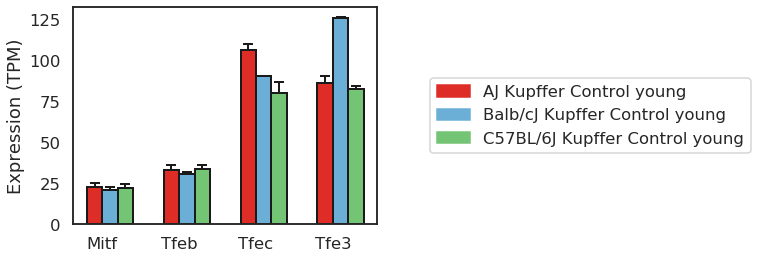

In [15]:
gene = ['Mitf', 'Tfeb', 'Tfec', 'Tfe3']

fig, axs = plt.subplots(1, 2,
                       figsize=(12, 4))

gene_list_bar_plot(gene,
                   tpm,
                   groups=groups,
                   group_labels = group_labels,
                   colors = colors,
                   width=0.2, 
                   ax=axs[0])

axs[0].get_legend().remove()

axs[1].legend(handles=legend_elements, loc='center')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')